# Machine Learning Challenge

Below are 2 data challenges that test for your ability to:
- Wrangle/clean data to make it usable by a model
- Figure out how to set up X's and y's for a use case, given a dataset
- Write code to robustly and reproducibly preprocess data
- Pick/design the right model, and tune hyperparameters to get the best performance

You can use any programming language, model, and package to solve these problems. Let us know of any assumptions you make in your process.

#### Deliverables:
- A link to a github repository that contains:
    - Clearly commented code that was written to solve these problems
    - Your trained models stored in a file (`.pkl`, `.h5`, `.tar` - whatever is appropriate). The models must have `predict(X)` functions. 
    - A readme file that contains:
        - Instructions to easily access/load the above
        - A writeup explaining any significant design decisions and your reasons for making them. 
        - If needed, a brief writeup explaining anything you are particularly proud of in your implementation that you might want us to focus on

#### How we'll assess your work:
- Accuracy/RMSE of your model when predicting on held-out data
- How well various edge cases are handled when testing on held-out data. For example, if the held-out data contains:
    - A new column that wasn't present in the dataset given to you
    - New value in a categorical field that wasn't seen in the dataset given to you
    - NA values
- Efficiency of the code. 
    - Is it easy to understand? 
    - Are the variable names descriptive? 
    - Are there any variables created that aren't used? 
    - Is redundant code replaced with function calls? 
    - Is vectorized implementation used instead of nested for loops? 
    - Are classes defined and objects created where applicable? 
    - Are packages used to perform tasks instead of implementing them from scratch?
    
**NOTE:** Your stored models, once loaded, should *just work* when fed with our held-out data (which looks similar to the data we've given you). We won't do any preprocessing before we feed it into the model's `predict(X)` function; `predict(X)` should handle the preprocessing. Pay particular attention to handling the edge cases we've talked about.

Feel free to ask questions to clarify things. Submit everything you tried, not just the things that worked. I encourage you to try and showcase your talents. The more you go above and beyond what's expected, the more impressed we'll be. **Bonus points if you fit Keras/Tensorflow/Pytorch/Caffe models** in addition to your Linear/Tree-based models.

## 0. Import dependencies

In [2]:
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt


from sklearn import preprocessing as scale
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, average_precision_score, precision_score, f1_score,recall_score, roc_auc_score

from math import sqrt
from numpy import concatenate
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

C:\Users\Prakash14\Anaconda3\envs\carnd-term1\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Using TensorFlow backend.


### Functions used in previous models

In [5]:
def preProcess(df):
    """
    Function to preprocess similar datasets: 
    Takes in a dataframe, checks for null values, replaces categorical value columns with dummy variables
    and fills the remaining null values in the numerical columns with the means of that column"""
    
    df.fillna(method='ffill', inplace=True)         #As the data is arranged chronologically, we fill the next missing variable with that of the previous hour/day
    df.fillna(method='bfill', inplace=True)         #Incase some NaNs are at the start
    
    categorical_columns = df.select_dtypes(include=['object'])
    dummy_columns = pd.get_dummies(categorical_columns)
    
    df = pd.concat([df.drop(categorical_columns, axis=1), dummy_columns], axis=1)
    
    return df

In [1]:
def dataSplit(df_X, y, dtype, test_size=0.2):
    """Function to split the training data into training, validation, and testing size and convert target variable to required type"""
    xtrain, xtest, ytrain, ytest = train_test_split(df_X, y, test_size = test_size, random_state = 19)
    
    ytrain, ytest = ytrain.astype(dtype), ytest.astype(dtype)
    return xtrain, xtest, ytrain, ytest

## Task 2
`forecasting_dataset.csv` is a file that contains pollution data for a city. Your task is to create a model that, when fed with columns `co_gt`, `nhmc`, `c6h6`, `s2`, `nox`, `s3`, `no2`, `s4`, `s5`, `t`, `rh`, `ah`, and `level`, predicts the value of `y` six hours later.

**NOTE:** In the data we've given you, the value of `y` for a given row is the value of `y` *for the timestamp of that same row*. We're asking you to predict the value of `y` 6 hours *after the timestamp of that row*.

In [ ]:
## What the data that we'll feed into your model's predict(X) function will look like:
# Notice what the level column looks like
pd.read_csv("forecasting_dataset.csv").drop(labels=['date', 'time', 'y'], axis='columns')

In [3]:
df = pd.read_csv("forecasting_dataset.csv", parse_dates=[['date','time']]).sort_values(by = ['date_time'])


In [6]:
df = preProcess(df.drop(['date_time'], axis =1))


In [7]:
df['y_6_hours_later'] = df.y.shift(-6)
df.dropna(inplace=True)

In [8]:
matrix = df.drop('y', axis=1).values
MinMax = scale.MinMaxScaler(feature_range=[-1,1])
scaled_data = MinMax.fit_transform(matrix)

In [9]:
scaled_data

array([[ 0.91222275, -0.49604032,  0.60712931, ..., -1.        ,
        -1.        ,  0.23660714],
       [ 0.9065597 , -0.55075594,  0.58816837, ..., -1.        ,
        -1.        ,  0.19285714],
       [ 0.90844738, -0.58531317,  0.58513462, ..., -1.        ,
        -1.        ,  0.15535714],
       ...,
       [ 0.8952336 , -1.        ,  0.53962837, ..., -1.        ,
        -1.        ,  0.125     ],
       [ 0.90184049, -1.        ,  0.55858931, ..., -1.        ,
        -1.        ,  0.17946429],
       [ 0.91694195, -1.        ,  0.61471369, ..., -1.        ,
        -1.        ,  0.17678571]])

In [10]:
X = scaled_data[:,:17]
y = scaled_data[:,17:]

In [11]:
scaled_data.shape

(8415, 18)

### Modelling

In [12]:
xtrain, xtest, ytrain, ytest = dataSplit(X, y, float, test_size=0.75)

In [13]:
xtrain.shape

(2103, 17)

In [14]:
xtrain = xtrain.reshape((xtrain.shape[0],1,xtrain.shape[1]))
xtest = xtest.reshape((xtest.shape[0],1,xtest.shape[1]))
print(xtrain.shape, ytrain.shape, xtest.shape,ytest.shape)

(2103, 1, 17) (2103, 1) (6312, 1, 17) (6312, 1)


### Network

In [15]:
model = Sequential()
model.add(LSTM(20, input_shape = (xtrain.shape[1],xtrain.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

Train on 2103 samples, validate on 6312 samples
Epoch 1/50
0s - loss: 0.0904 - val_loss: 0.0766
Epoch 2/50
0s - loss: 0.0661 - val_loss: 0.0631
Epoch 3/50
0s - loss: 0.0559 - val_loss: 0.0580
Epoch 4/50
0s - loss: 0.0514 - val_loss: 0.0561
Epoch 5/50
0s - loss: 0.0494 - val_loss: 0.0558
Epoch 6/50
0s - loss: 0.0486 - val_loss: 0.0558
Epoch 7/50
0s - loss: 0.0482 - val_loss: 0.0557
Epoch 8/50
0s - loss: 0.0479 - val_loss: 0.0556
Epoch 9/50
0s - loss: 0.0477 - val_loss: 0.0554
Epoch 10/50
0s - loss: 0.0474 - val_loss: 0.0553
Epoch 11/50
0s - loss: 0.0472 - val_loss: 0.0552
Epoch 12/50
0s - loss: 0.0470 - val_loss: 0.0551
Epoch 13/50
0s - loss: 0.0469 - val_loss: 0.0550
Epoch 14/50
0s - loss: 0.0467 - val_loss: 0.0549
Epoch 15/50
0s - loss: 0.0466 - val_loss: 0.0548
Epoch 16/50
0s - loss: 0.0464 - val_loss: 0.0548
Epoch 17/50
0s - loss: 0.0463 - val_loss: 0.0547
Epoch 18/50
0s - loss: 0.0462 - val_loss: 0.0547
Epoch 19/50
0s - loss: 0.0461 - val_loss: 0.0546
Epoch 20/50
0s - loss: 0.0460 

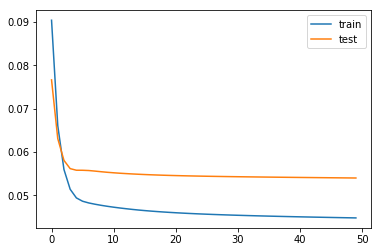

In [16]:
#fit
history = model.fit(xtrain, ytrain, nb_epoch=50, batch_size=128, validation_data=(xtest,ytest), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Evaluation

In [17]:
y_pred = model.predict(xtest)
xtest = xtest.reshape((xtest.shape[0], xtest.shape[2])) #reshaping it back

In [18]:
xtest.shape

(6312, 17)

In [19]:
#inver scaling to forecast
y_pred_inv = concatenate((y_pred, xtest[:,:]), axis=1)
print(y_pred_inv.shape)
y_pred_inv = MinMax.inverse_transform(y_pred_inv)
y_pred_inv = y_pred_inv[:,0]

(6312, 18)


In [20]:
#inver scaling for truth value
ytest = ytest.reshape((len(ytest),1))
y_inv = concatenate((ytest, xtest[:,:]), axis=1)
y_inv = MinMax.inverse_transform(y_inv)
y_inv = y_inv[:,0]

In [21]:
rmse = sqrt(mean_squared_error(y_inv, y_pred_inv))

In [22]:
rmse

24.61316980929556